In [1]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.ldamodel import LdaModel
from collections import Counter
from operator import itemgetter

from top2vec import Top2Vec


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dxlee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\dxlee\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load process_csv_stage_1.csv

In [2]:
df = pd.read_csv('process_csv_stage_1.csv')
df.columns = ['old_index','preprocessed_text']
df

old_index                                  preprocessed_text
0              1  good morning name appreciate could help put st...
1              2  upgraded card tell agent upgrade anniversary d...
2             10  chase card report however fraudulent applicati...
3             11  try book ticket come across offer apply toward...
4             14  grand son give check deposit chase account fun...
...          ...                                                ...
21067      78303  chase card customer well decade offer multiple...
21068      78309  wednesday call chas visa credit card provider ...
21069      78310  familiar pay understand great risk provide con...
21070      78311  flawless credit chase credit card chase freedo...
21071      78312  roughly year ago close account morgan chase ba...

[21072 rows x 2 columns]

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = df['preprocessed_text']

tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95
)

tfidf = tfidf_vectorizer.fit_transform(texts)

tfidf

<21072x11274 sparse matrix of type '<class 'numpy.float64'>'
	with 1392456 stored elements in Compressed Sparse Row format>

# Load complaint_what_happened from json

In [3]:
# load raw complaint json into raw df 
raw = pd.json_normalize(json.load(open("complaints-2021-05-14_08_16_.json")))

# renaming column
raw.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

# drop unnecessary columns
raw.drop(['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'sub_issue','consumer_consent_provided'],axis=1,inplace=True)

# drop null values
raw['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
raw.dropna(inplace=True)

# clear masked values
def remove_mask(text):
    masked_text_pattern = r"\b[x|X]{2,20}"
    return re.sub(masked_text_pattern,'',text)

removed_mask = raw.complaint_what_happened.apply(remove_mask)

# Topic Modelling

## Non-Negative Matrix Factorisation

k = 2; Coherence Score = 0.31873
k = 3; Coherence Score = 0.36078
k = 4; Coherence Score = 0.39091
k = 5; Coherence Score = 0.37641
k = 6; Coherence Score = 0.37683
k = 7; Coherence Score = 0.38585
k = 8; Coherence Score = 0.39049
k = 9; Coherence Score = 0.41091
k = 10; Coherence Score = 0.40705
k = 11; Coherence Score = 0.41113
k = 12; Coherence Score = 0.40875
k = 13; Coherence Score = 0.40078
k = 14; Coherence Score = 0.40042
k = 15; Coherence Score = 0.40835


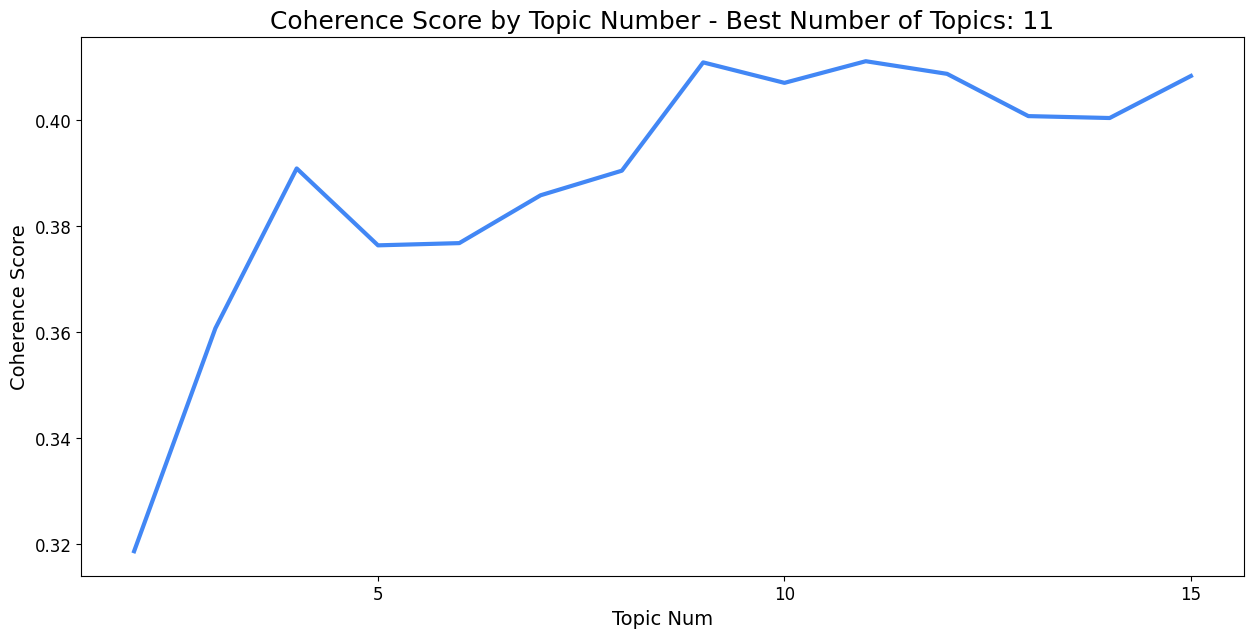

In [27]:
# Coherence Score Evaluation Score is available in the package gensim, 
# thus find the best number of topics using gensim NMF models

texts = df['preprocessed_text'].str.split(' ')

dictionary = Dictionary(texts)

dictionary.filter_extremes(
    no_below=2,
    no_above=0.95,
    keep_n=5000
)

corpus = [dictionary.doc2bow(text) for text in texts]

topic_nums = list(np.arange(2, 15 + 1, 1))

coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))
    print(f'k = {num}; Coherence Score = {round(cm.get_coherence(), 5)}')

scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [28]:
final_nmf = Nmf(
        corpus=corpus,
        num_topics=best_num_topics,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
final_nmf.print_topics()

[(0,
  '0.156*"credit" + 0.057*"report" + 0.016*"inquiry" + 0.014*"request" + 0.014*"score" + 0.013*"year" + 0.013*"loan" + 0.011*"application" + 0.011*"reporting" + 0.011*"chase"'),
 (1,
  '0.111*"payment" + 0.029*"make" + 0.023*"pay" + 0.014*"report" + 0.013*"due" + 0.013*"late" + 0.012*"time" + 0.012*"month" + 0.011*"balance" + 0.011*"mortgage"'),
 (2,
  '0.036*"loan" + 0.015*"would" + 0.015*"mortgage" + 0.013*"service" + 0.012*"home" + 0.012*"modification" + 0.011*"fee" + 0.009*"property" + 0.009*"receive" + 0.008*"document"'),
 (3,
  '0.152*"chase" + 0.043*"bank" + 0.023*"pay" + 0.020*"payment" + 0.018*"time" + 0.018*"transaction" + 0.018*"make" + 0.016*"amount" + 0.013*"fee" + 0.011*"also"'),
 (4,
  '0.030*"say" + 0.028*"call" + 0.026*"bank" + 0.026*"get" + 0.024*"tell" + 0.021*"money" + 0.017*"back" + 0.014*"would" + 0.014*"check" + 0.012*"ask"'),
 (5,
  '0.026*"dispute" + 0.024*"consumer" + 0.020*"service" + 0.014*"act" + 0.013*"information" + 0.012*"provide" + 0.011*"request" 

In [29]:
nmf_topics = []
for index, topic in final_nmf.show_topics(formatted=False, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    nmf_topics.append([w[0] for w in topic])

Topic: 2 
Words: ['loan', 'would', 'mortgage', 'service', 'home', 'modification', 'fee', 'property', 'receive', 'document']
Topic: 5 
Words: ['dispute', 'consumer', 'service', 'act', 'information', 'provide', 'request', 'merchant', 'report', 'may']
Topic: 4 
Words: ['say', 'call', 'bank', 'get', 'tell', 'money', 'back', 'would', 'check', 'ask']
Topic: 7 
Words: ['chase', 'letter', 'receive', 'claim', 'send', 'state', 'provide', 'fraud', 'document', 'dispute']
Topic: 3 
Words: ['chase', 'bank', 'pay', 'payment', 'time', 'transaction', 'make', 'amount', 'fee', 'also']
Topic: 10 
Words: ['charge', 'call', 'card', 'would', 'receive', 'fraud', 'dispute', 'make', 'credit', 'time']
Topic: 9 
Words: ['account', 'bank', 'close', 'money', 'transaction', 'fraud', 'open', 'balance', 'claim', 'fund']
Topic: 8 
Words: ['card', 'credit', 'purchase', 'chase', 'balance', 'pay', 'fee', 'apply', 'use', 'point']
Topic: 0 
Words: ['credit', 'report', 'inquiry', 'request', 'score', 'year', 'loan', 'applicat

In [32]:
# sklearn NMF
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=best_num_topics, random_state=42)
nmf_model.fit(tfidf)
len(tfidf_vectorizer.get_feature_names_out())


11274

In [33]:
H = nmf_model.components_

In [35]:
#Print the Top15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((best_num_topics, 15)), index=[f'Topic {i + 1}' for i in range(best_num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(best_num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

Word 1    Word 2       Word 3     Word 4        Word 5      Word 6  \
Topic 1   account     close         open      chase        reason      saving   
Topic 2      card    credit        chase      apply           use       limit   
Topic 3      loan  mortgage        chase       home  modification    property   
Topic 4    charge   dispute     merchant      chase        refund  fraudulent   
Topic 5   payment      late         make        pay           due       month   
Topic 6    report    credit         debt     remove        bureau   reporting   
Topic 7      call      tell          say      would           get         ask   
Topic 8   inquiry      hard       credit  authorize        remove      report   
Topic 9      bank     money  transaction      chase         claim         atm   
Topic 10    check   deposit         fund       cash          bank        hold   
Topic 11      fee   balance     interest     charge           pay   overdraft   

                Word 7       Word 8       Word 9    Word 10        Word 11  \
Topic 1         access      without     business       bank            new   
Topic 2          score        offer     purchase     amazon    application   
Topic 3           year  foreclosure         rate       sale      refinance   
Topic 4        provide     purchase  transaction      claim          fraud   
Topic 5           auto        chase    statement    monthly            day   
Topic 6    information         file        theft   identity        company   
Topic 7           back        phone      receive     number          could   
Topic 8   unauthorized          add        apply  initiated  authorization   
Topic 9          fraud        debit     transfer       fund            use   
Topic 10         chase          day       branch      clear        account   
Topic 11        annual         rate         full   transfer      statement   

               Word 12      Word 13  Word 14      Word 15  
Topic 1         branch       online     name       closed  
Topic 2          point       reward    close          new  
Topic 3       document        house      pay       morgan  
Topic 4        company       amount  receive      service  
Topic 5         amount         time     bill         date  
Topic 6           late       agency     show   collection  
Topic 7            day         send     time        speak  
Topic 8   verification  application     pull  permissible  
Topic 9           take         make     wire      account  
Topic 10     available        money  release       direct  
Topic 11         month       amount     bill          due

In [63]:
import pickle
import os

filename_nmf = 'final_nmf.sav'

pickle.dump(final_nmf, open(os.path.join(os.getcwd(),'topic_models',filename_nmf), 'wb'))

## Latent Dirichlet Allocation

k = 2; Coherence Score = 0.33876
k = 3; Coherence Score = 0.35982
k = 4; Coherence Score = 0.39096
k = 5; Coherence Score = 0.37259
k = 6; Coherence Score = 0.37986
k = 7; Coherence Score = 0.39036
k = 8; Coherence Score = 0.39802
k = 9; Coherence Score = 0.40778
k = 10; Coherence Score = 0.41887
k = 11; Coherence Score = 0.41423
k = 12; Coherence Score = 0.42018
k = 13; Coherence Score = 0.42637
k = 14; Coherence Score = 0.4181
k = 15; Coherence Score = 0.42322


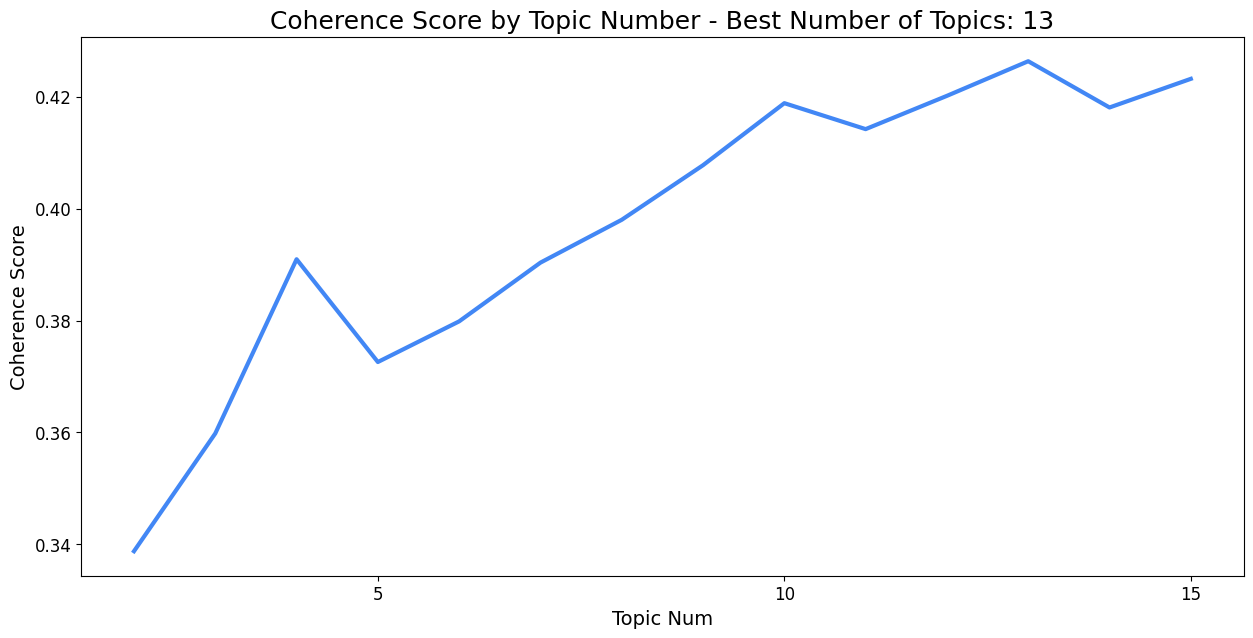

In [36]:
texts = df['preprocessed_text'].str.split(' ')

dictionary = Dictionary(texts)

dictionary.filter_extremes(
    no_below=2,
    no_above=0.95,
    keep_n=5000
)

corpus = [dictionary.doc2bow(text) for text in texts]

topic_nums = list(np.arange(2, 15 + 1, 1))

coherence_scores = []

for num in topic_nums:
    lda = LdaModel(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        minimum_probability=0.01,
        alpha='symmetric',
        eta= 0.7,
        per_word_topics=True,
        eval_every=10,
        random_state=42
    )
    cm = CoherenceModel(
        model=lda,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))
    print(f'k = {num}; Coherence Score = {round(cm.get_coherence(), 5)}')

scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [37]:
final_lda = LdaModel(
    corpus=corpus,
    num_topics=best_num_topics,
    id2word=dictionary,
    chunksize=2000,
    passes=5,
    minimum_probability=0.01,
    alpha='symmetric',
    eta= 0.7,
    per_word_topics=True,
    eval_every=10,
    random_state=42
)
final_lda.print_topics()

[(0,
  '0.030*"get" + 0.029*"call" + 0.029*"say" + 0.025*"tell" + 0.021*"would" + 0.015*"back" + 0.014*"could" + 0.014*"time" + 0.013*"ask" + 0.012*"money"'),
 (1,
  '0.044*"chase" + 0.043*"charge" + 0.034*"dispute" + 0.017*"card" + 0.016*"credit" + 0.015*"merchant" + 0.015*"refund" + 0.012*"receive" + 0.011*"purchase" + 0.010*"provide"'),
 (2,
  '0.132*"credit" + 0.076*"card" + 0.054*"chase" + 0.043*"report" + 0.038*"account" + 0.012*"remove" + 0.012*"score" + 0.012*"bank" + 0.010*"close" + 0.009*"year"'),
 (3,
  '0.062*"card" + 0.041*"fee" + 0.033*"charge" + 0.032*"chase" + 0.023*"credit" + 0.019*"offer" + 0.014*"purchase" + 0.013*"point" + 0.011*"use" + 0.010*"apply"'),
 (4,
  '0.044*"chase" + 0.032*"fraud" + 0.031*"transaction" + 0.029*"claim" + 0.026*"card" + 0.025*"account" + 0.022*"bank" + 0.019*"charge" + 0.018*"fraudulent" + 0.014*"make"'),
 (5,
  '0.081*"car" + 0.049*"inquiry" + 0.035*"vehicle" + 0.034*"auto" + 0.029*"lease" + 0.024*"finance" + 0.023*"insurance" + 0.022*"cred

In [43]:
lda_topics = []
for index, topic in final_lda.show_topics(formatted=False, num_topics=best_num_topics, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    lda_topics.append([w[0] for w in topic])

Topic: 0 
Words: ['get', 'call', 'say', 'tell', 'would', 'back', 'could', 'time', 'ask', 'money']
Topic: 1 
Words: ['chase', 'charge', 'dispute', 'card', 'credit', 'merchant', 'refund', 'receive', 'purchase', 'provide']
Topic: 2 
Words: ['credit', 'card', 'chase', 'report', 'account', 'remove', 'score', 'bank', 'close', 'year']
Topic: 3 
Words: ['card', 'fee', 'charge', 'chase', 'credit', 'offer', 'purchase', 'point', 'use', 'apply']
Topic: 4 
Words: ['chase', 'fraud', 'transaction', 'claim', 'card', 'account', 'bank', 'charge', 'fraudulent', 'make']
Topic: 5 
Words: ['car', 'inquiry', 'vehicle', 'auto', 'lease', 'finance', 'insurance', 'credit', 'report', 'hard']
Topic: 6 
Words: ['payment', 'pay', 'chase', 'make', 'balance', 'late', 'interest', 'due', 'month', 'amount']
Topic: 7 
Words: ['debt', 'consumer', 'law', 'act', 'chase', 'information', 'provide', 'state', 'bank', 'right']
Topic: 8 
Words: ['account', 'check', 'bank', 'chase', 'fund', 'deposit', 'money', 'day', 'fee', 'cash']

In [44]:
print('\nPerplexity: ', final_lda.log_perplexity(corpus))  

coherence_model_lda = CoherenceModel(model=final_lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.488433088714334

Coherence Score:  0.42637478939528306


In [45]:
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
coherence_per_topic 

[0.42587483070394894,
 0.4090394667561318,
 0.3847259355052723,
 0.4261270114014836,
 0.4723971859899853,
 0.41621744422118684,
 0.42144097220379645,
 0.4304117597550734,
 0.4248816729242083,
 0.4170473184471585,
 0.4018335909515954,
 0.5384102717601513,
 0.3744648015186885]

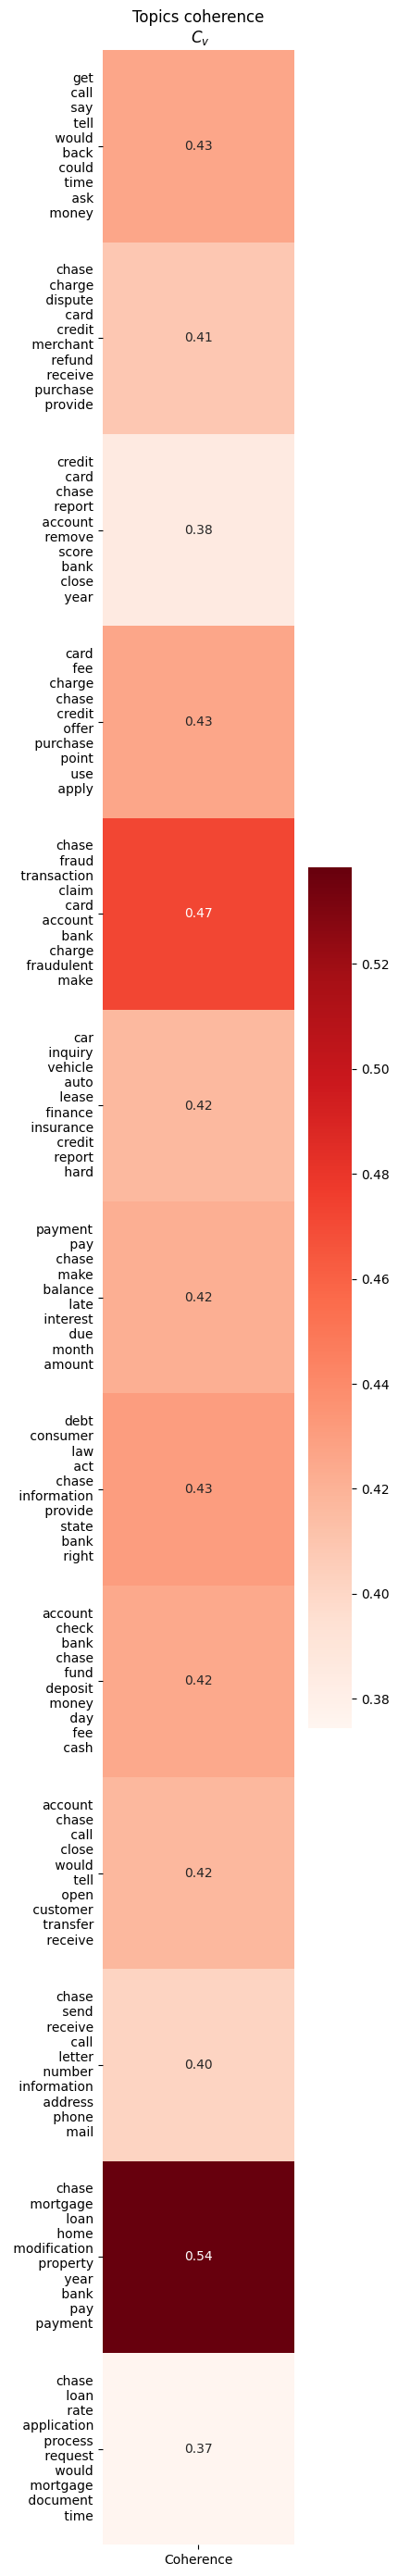

In [48]:
# coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
topics_str = [ '\n '.join(t) for t in lda_topics ]
data_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(4, 35) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()

In [64]:
import pickle, os
filename_lda = 'final_lda.sav'
pickle.dump(final_lda, open(os.path.join(os.getcwd(),'topic_models',filename_lda), 'wb'))

## Top2Vec

In [13]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42}
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'}

top2vec = Top2Vec(
    documents= list(removed_mask), 
    speed='deep-learn', 
    workers=8, 
    min_count = 0, 
    embedding_model='universal-sentence-encoder', 
    umap_args = umap_args, 
    hdbscan_args = hdbscan_args)

top2vec.get_num_topics()

2024-06-03 22:04:29,979 - top2vec - INFO - Pre-processing documents for training
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-06-03 22:04:51,290 - top2vec - INFO - Downloading universal-sentence-encoder model
2024-06-03 22:05:08,880 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-06-03 22:05:59,606 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
c:\Users\dxlee\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-06-03 22:07:32,412 - top2vec - IN

7

In [14]:
top2vec.topic_words

array([['chexsystems', 'cfpb', 'autopay', 'bofa', 'lifelock', 'usaa',
        'citibank', 'repoed', 'chase', 'wamu', 'overdrawn', 'kyc',
        'wellsfargo', 'transunion', 'garnishment', 'preapproval', 'pnc',
        'experian', 'chargebacks', 'echeck', 'churning', 'defaulted',
        'citi', 'overdrafted', 'garnishments', 'overdrafts',
        'chargeback', 'overdraft', 'garnished', 'refinanced', 'bank',
        'defrauded', 'fdic', 'creditor', 'creditors', 'heloc', 'banking',
        'reposession', 'refi', 'insolvent', 'equifax', 'creditcard',
        'debtors', 'amex', 'receivables', 'santander', 'overdraw',
        'fraudsters', 'lender', 'hsbc'],
       ['experian', 'dispute', 'lifelock', 'transunion', 'garnishment',
        'creditor', 'chexsystems', 'equifax', 'defrauded', 'repoed',
        'receivables', 'disputes', 'garnished', 'creditors', 'disputing',
        'litigation', 'garnishing', 'collections', 'fraudulent',
        'bureaus', 'autopay', 'forclosure', 'debtor', 'bai

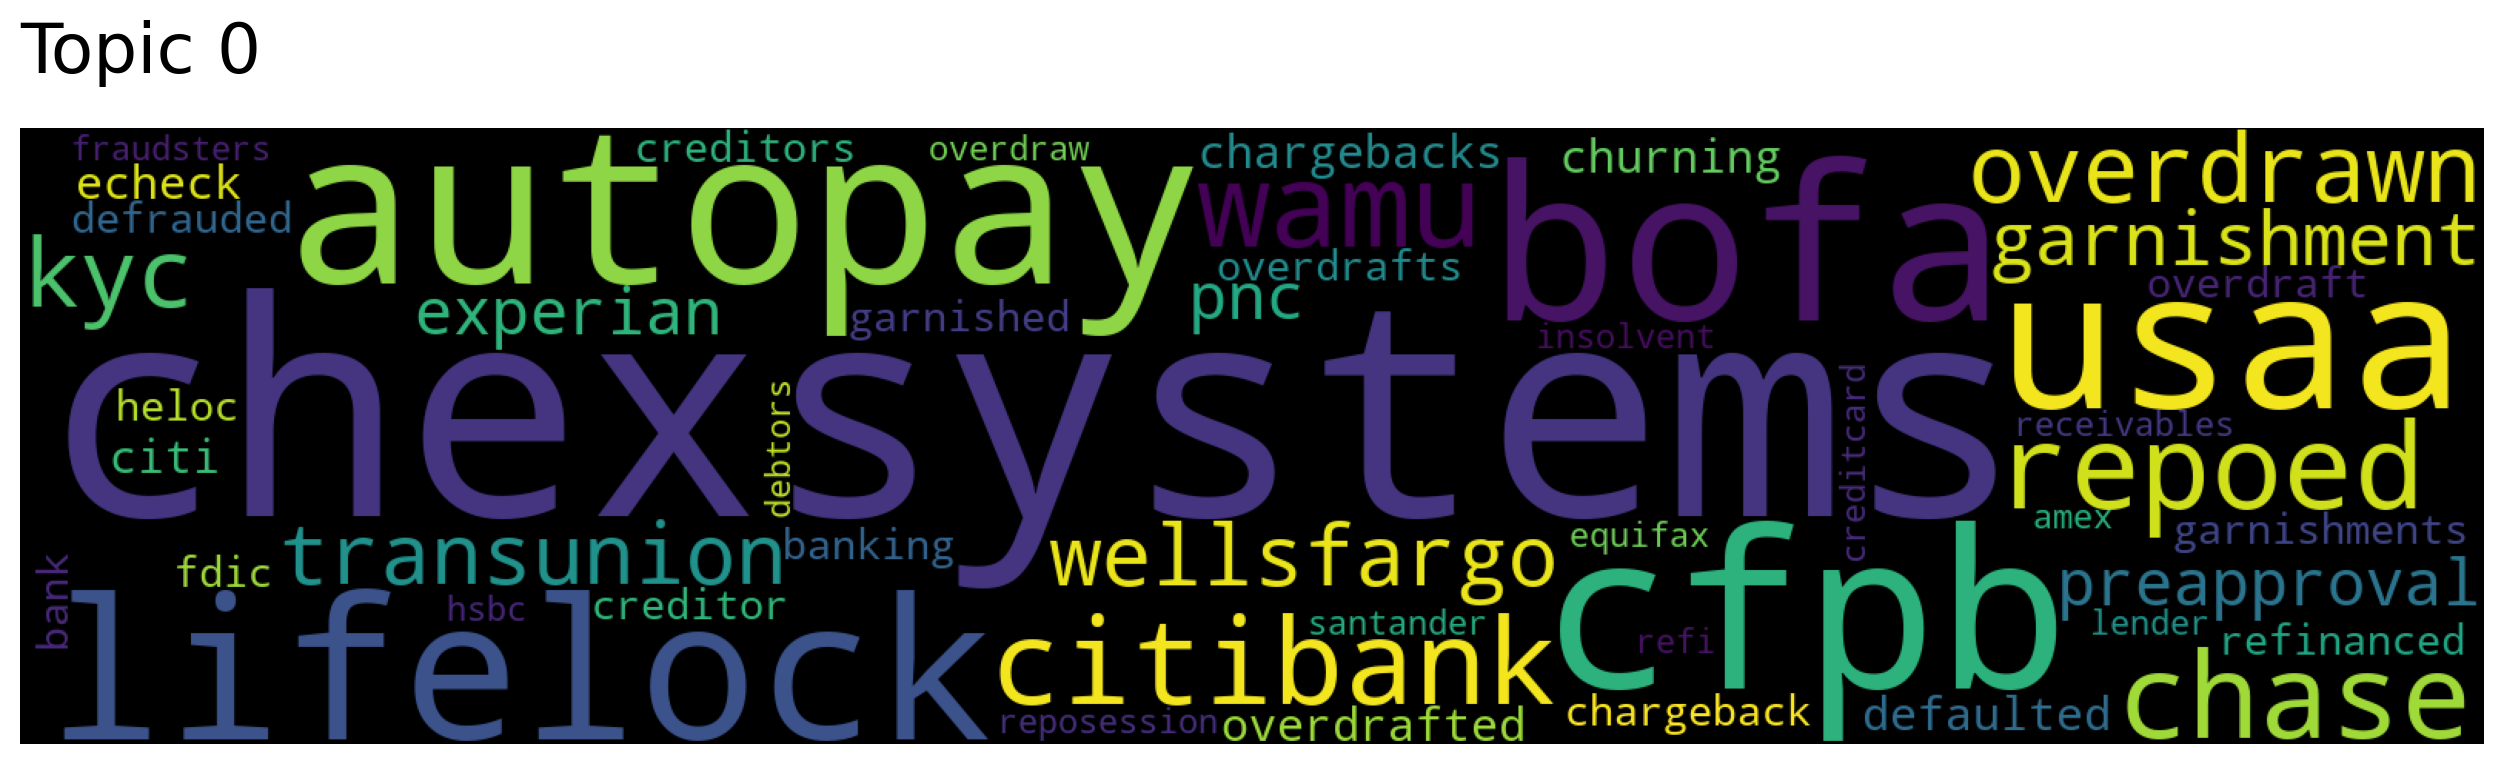

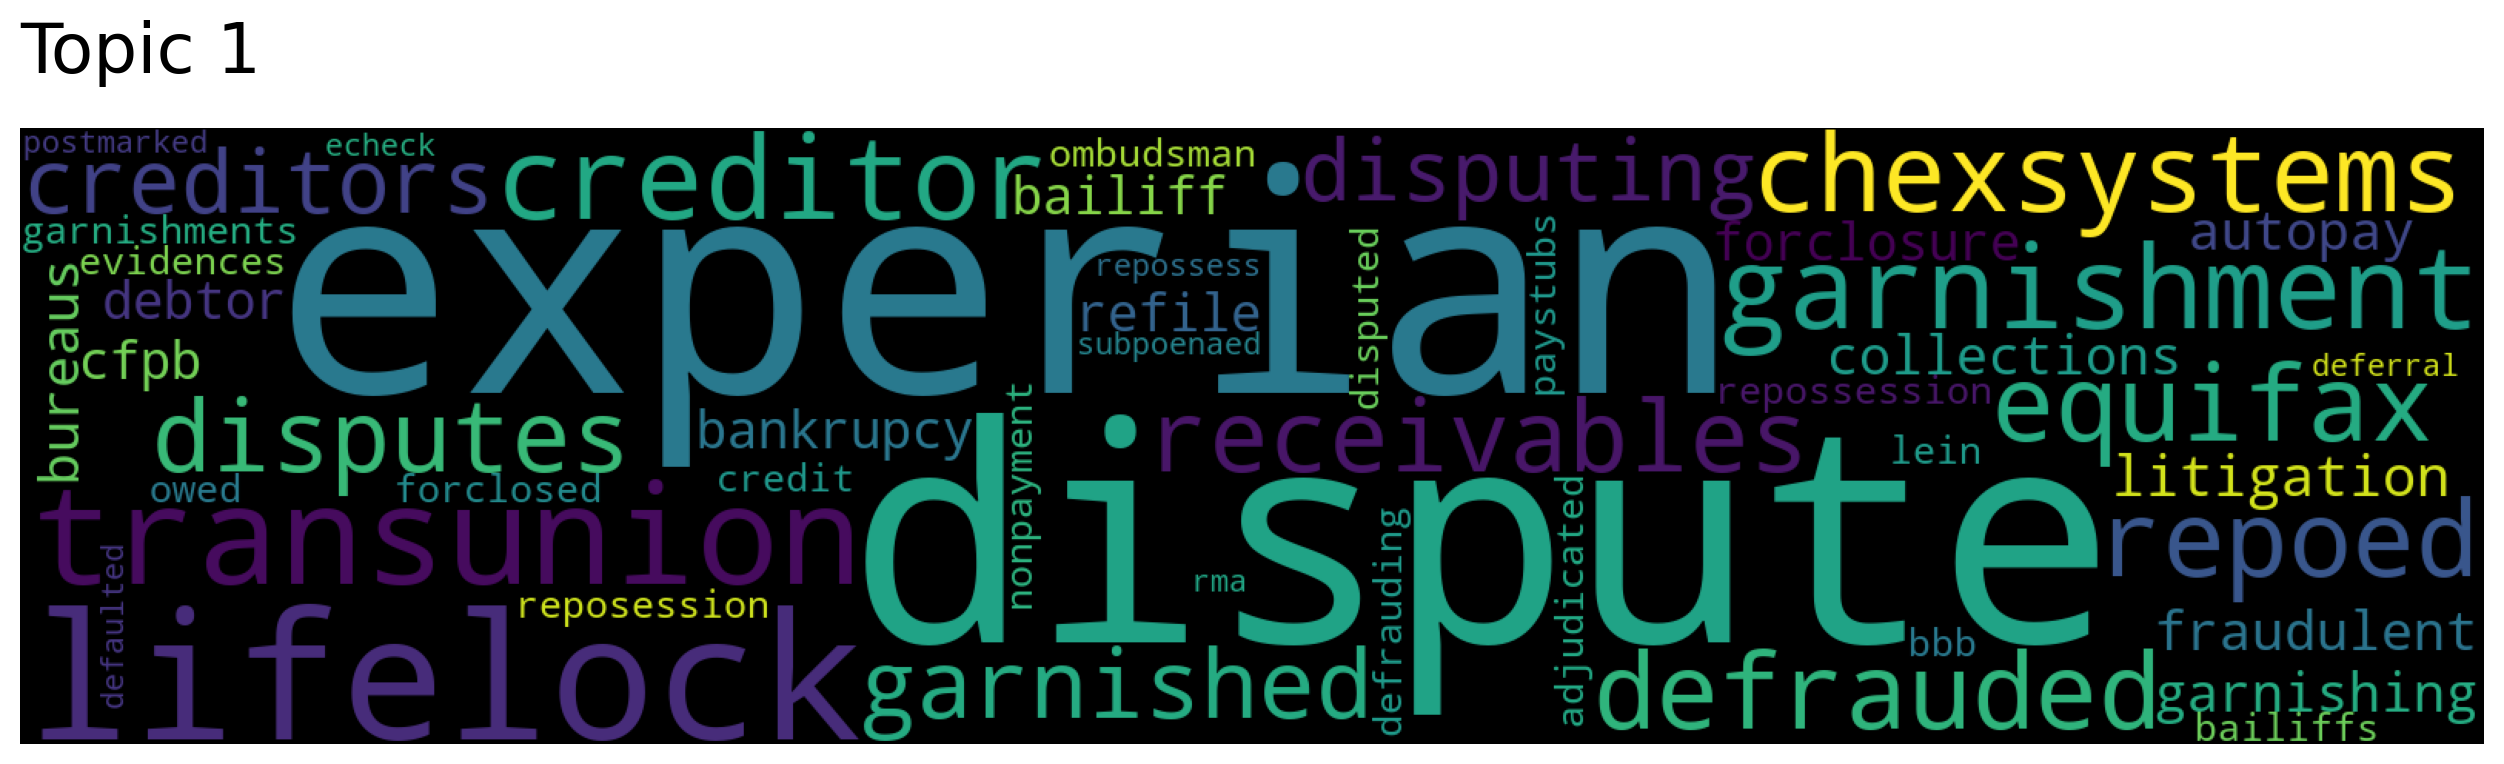

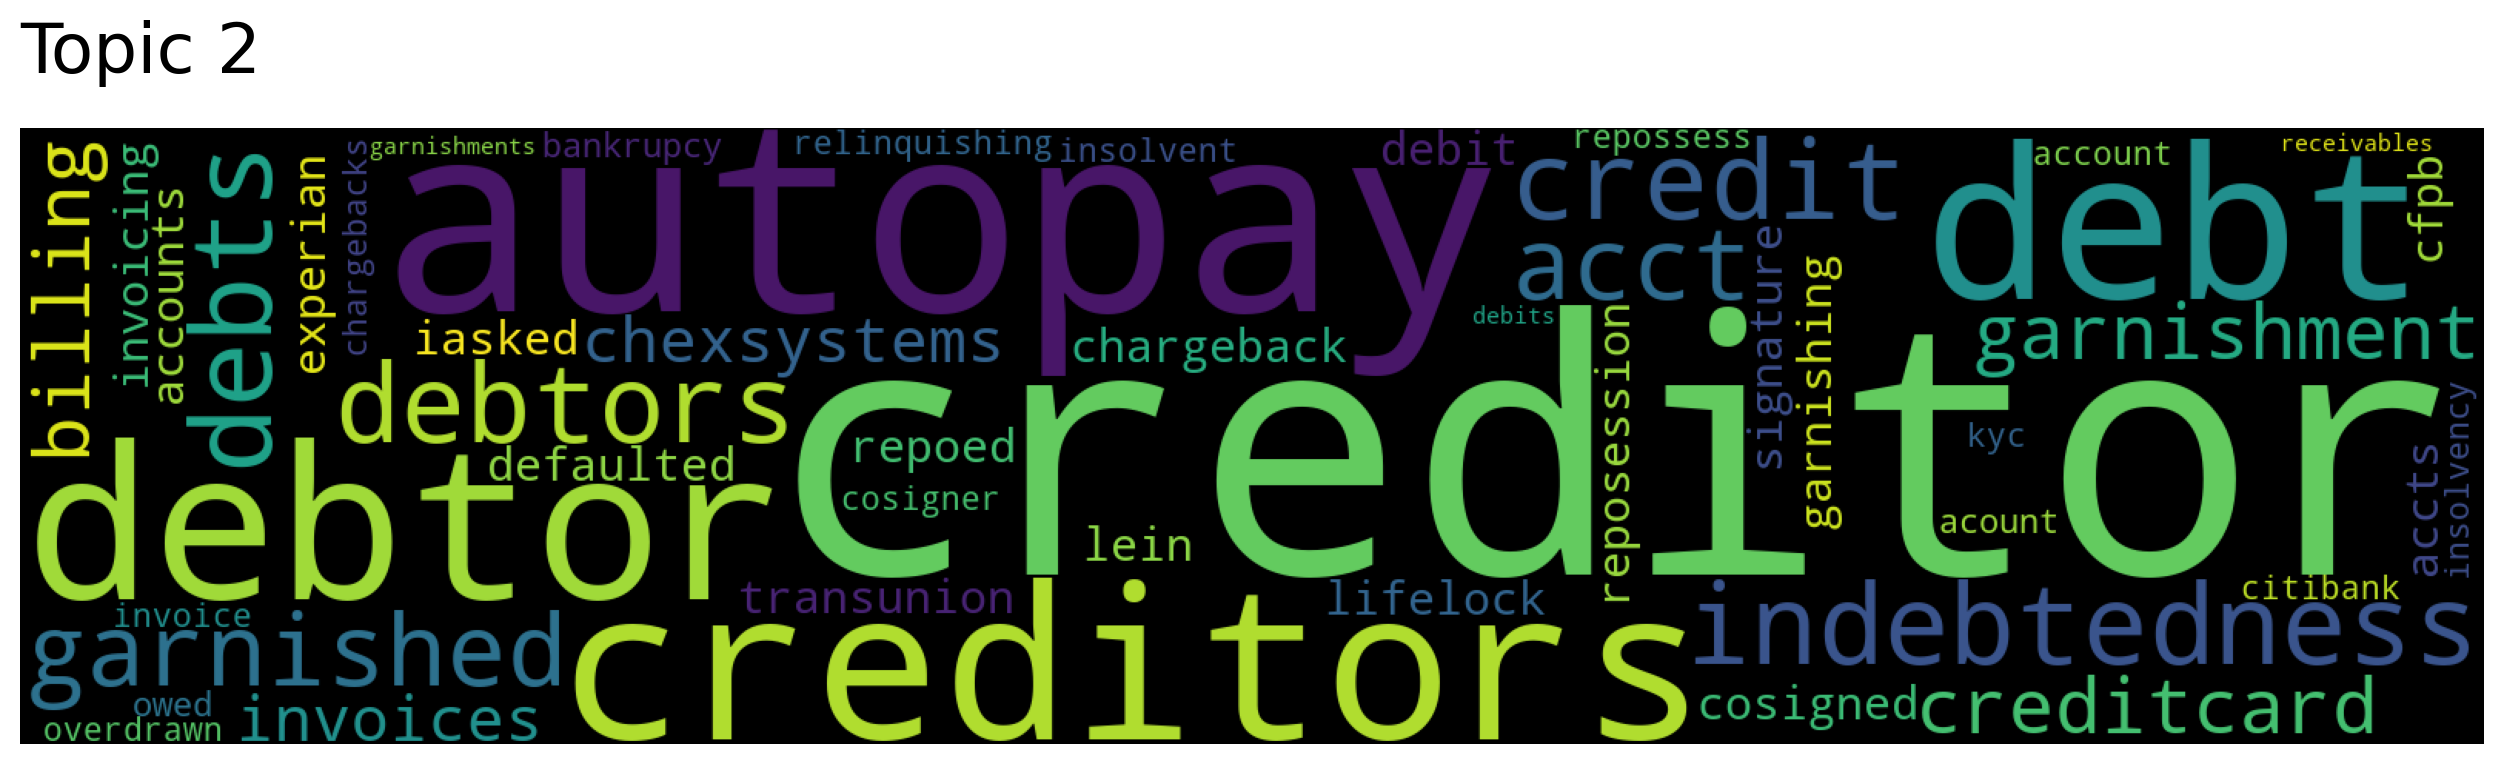

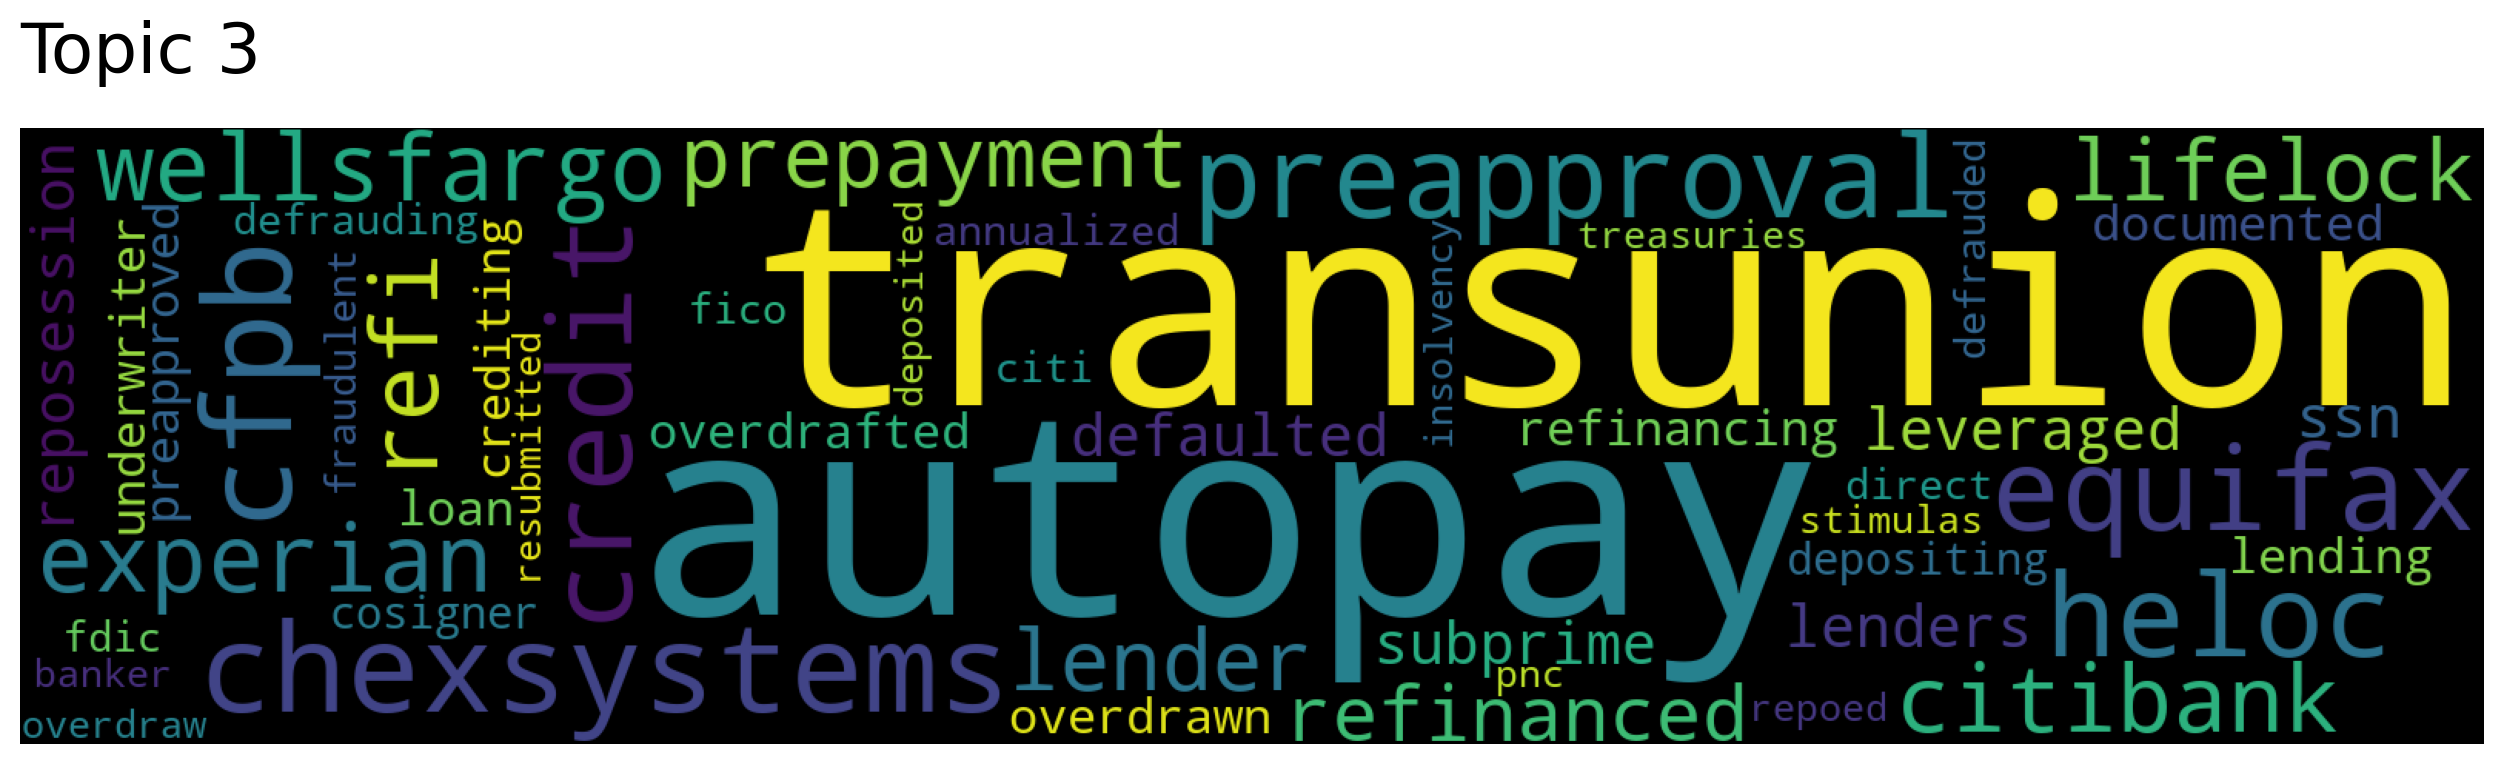

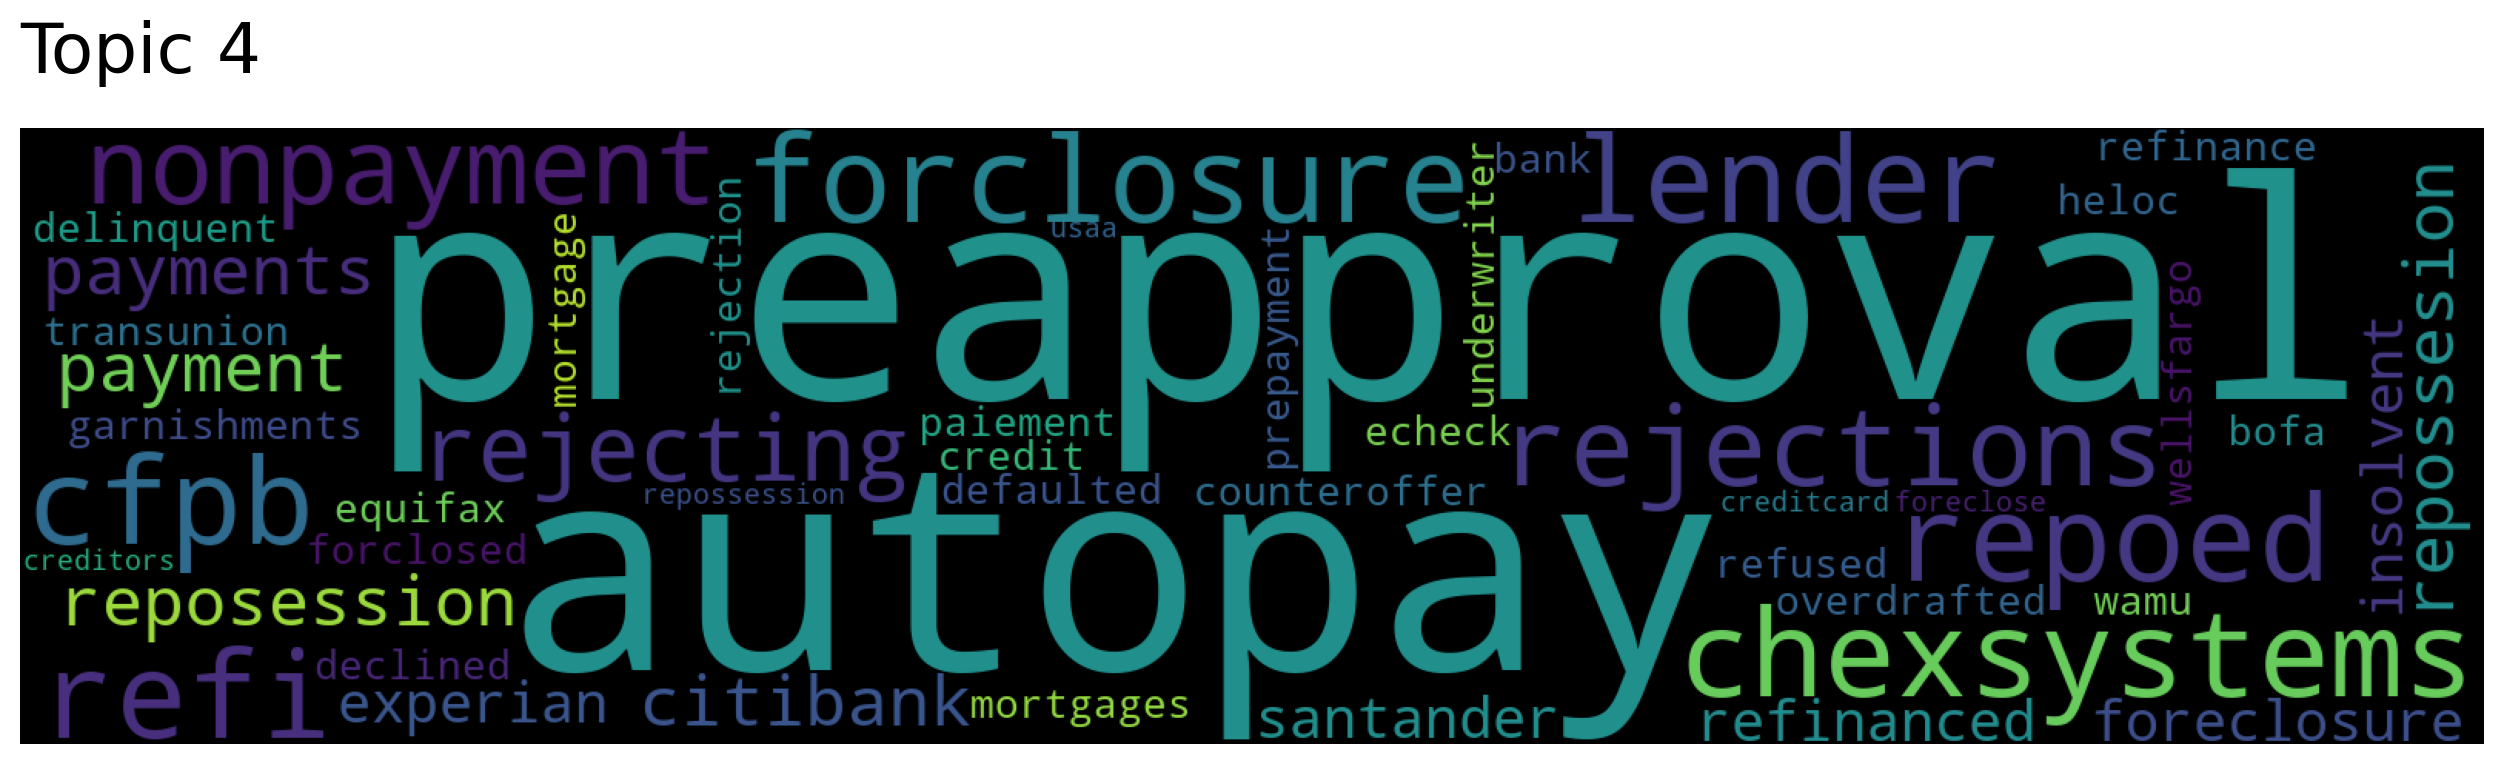

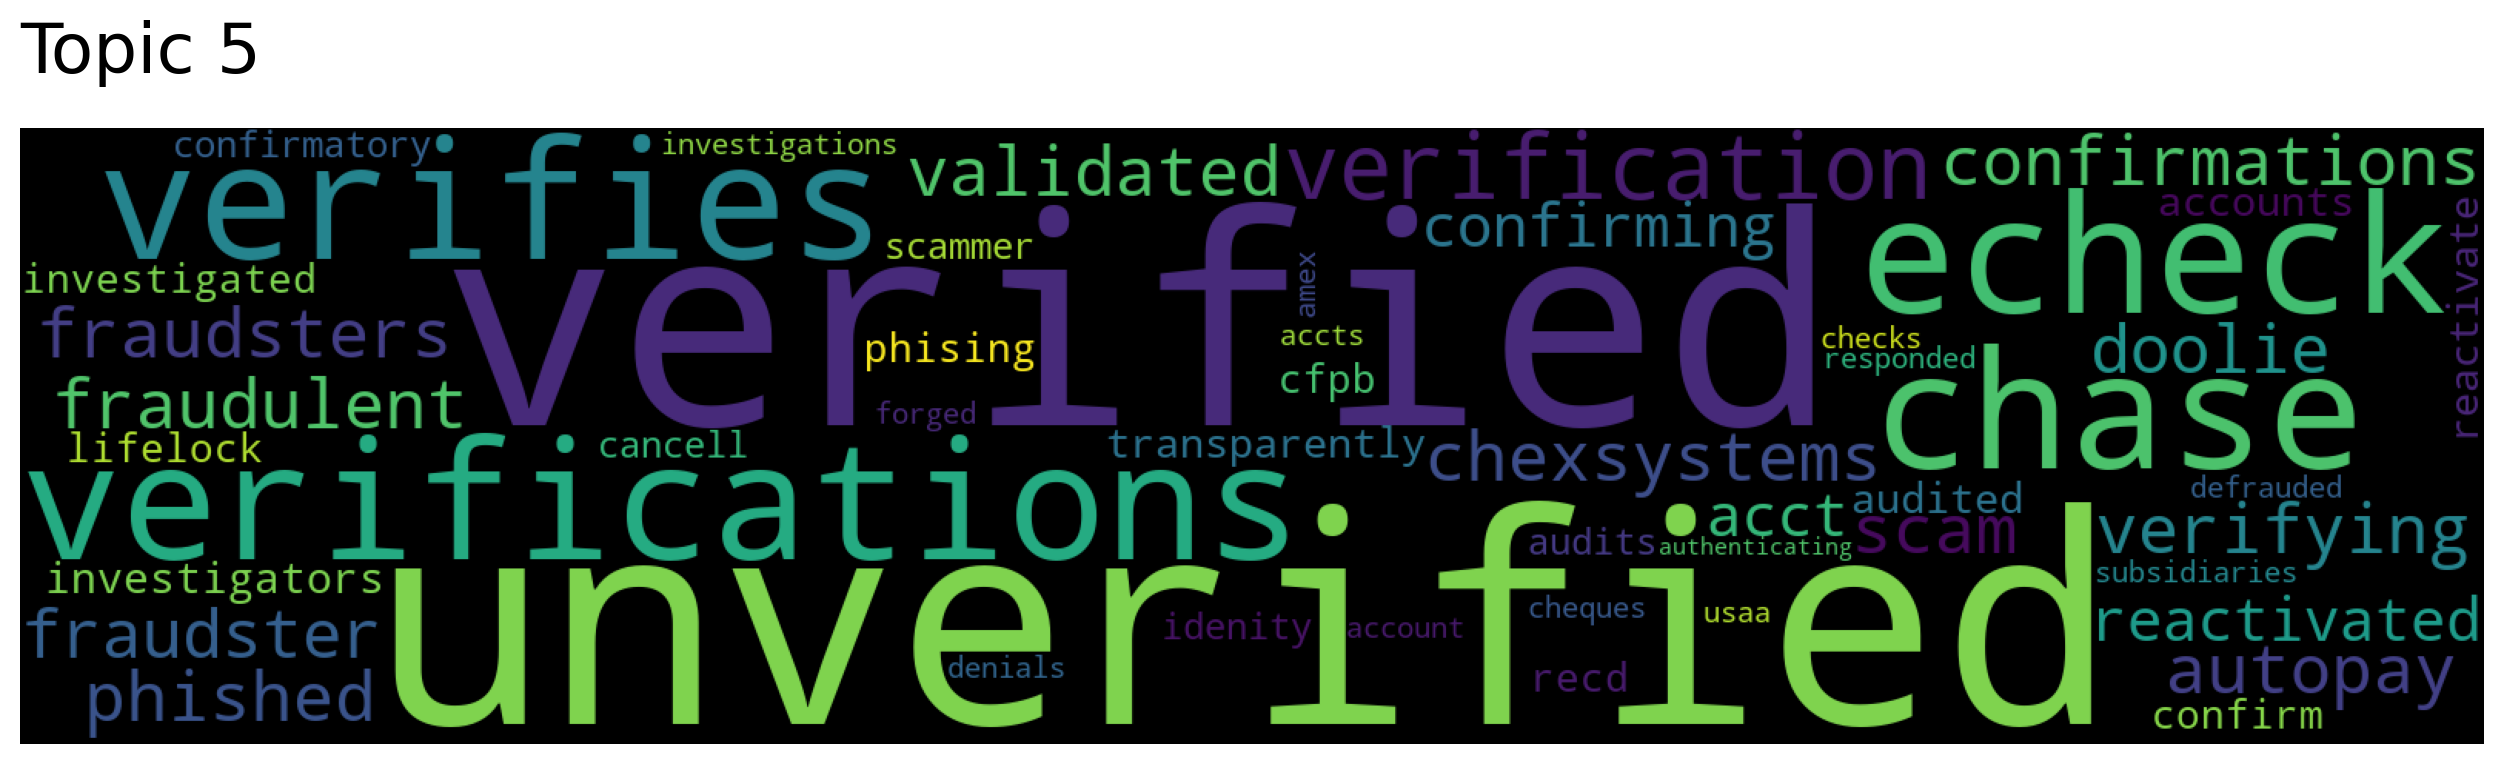

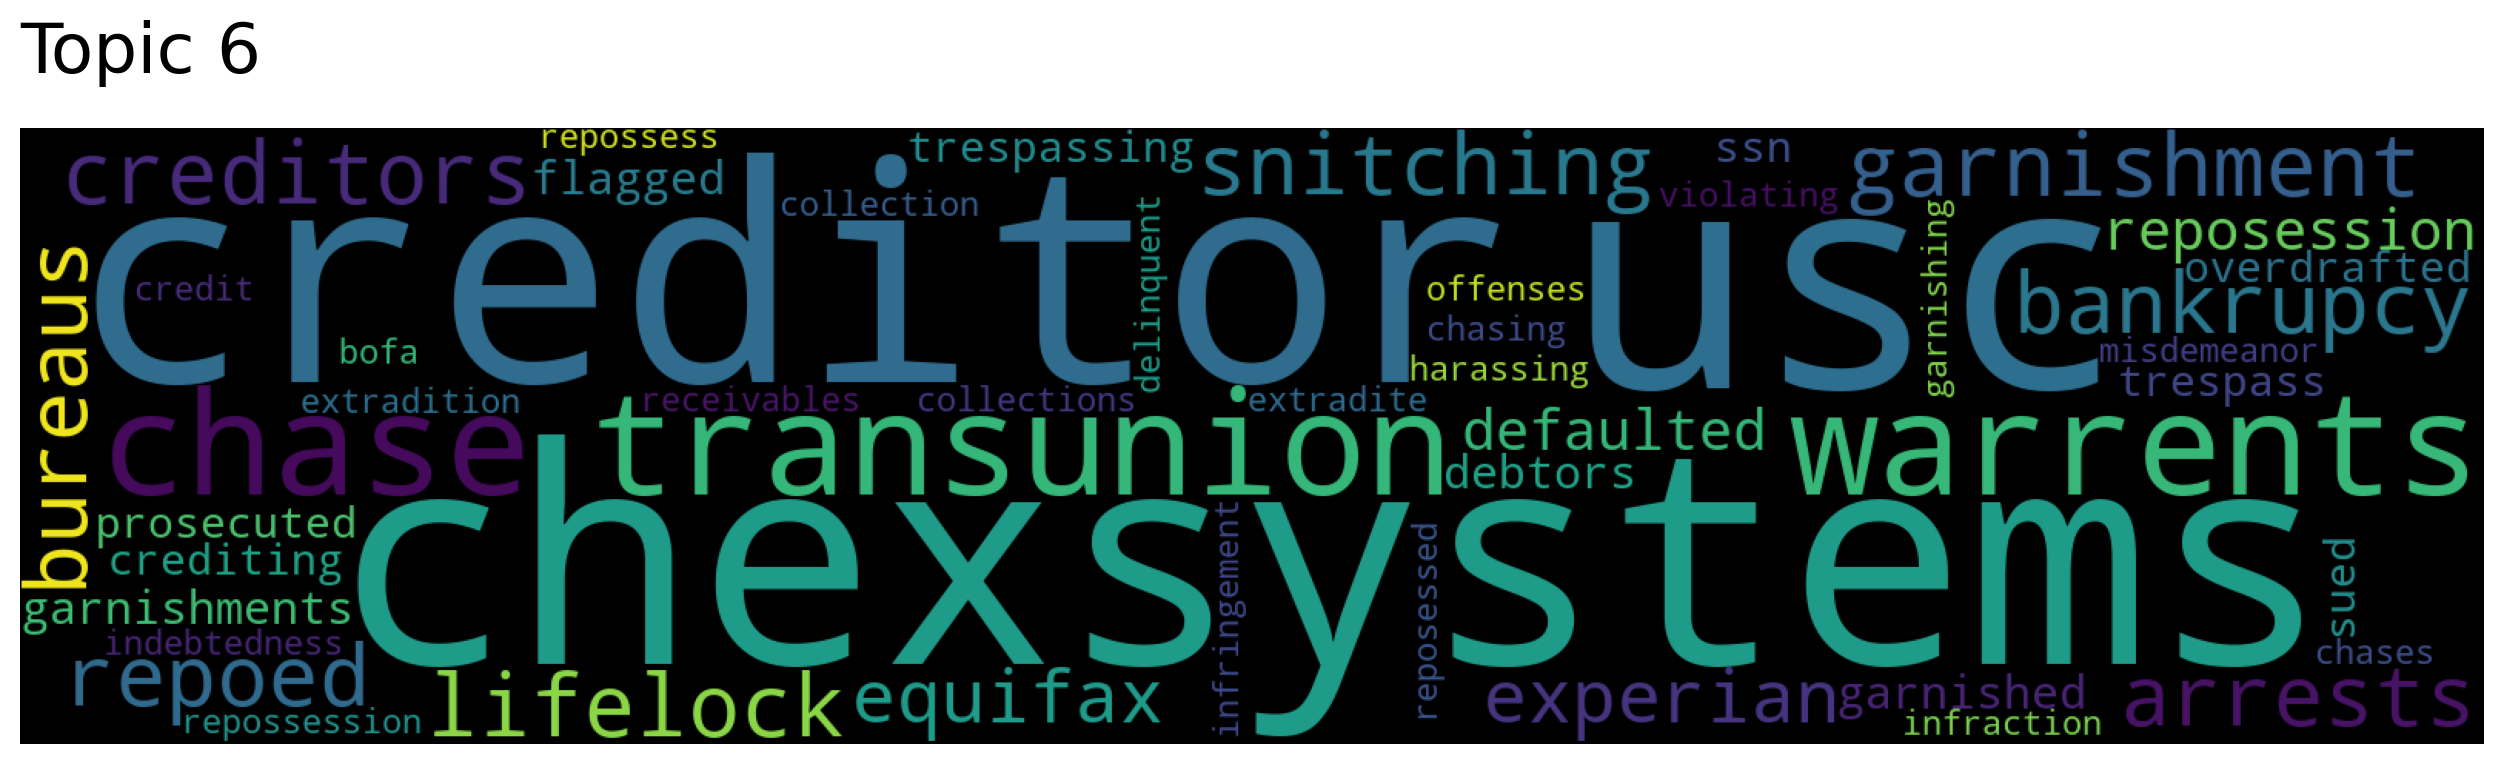

In [15]:
topic_words, word_scores, topic_nums = top2vec.get_topics(7)
for topic in topic_nums:
    top2vec.generate_topic_wordcloud(topic, background_color="black")

In [65]:
import os
top2vec.save(os.path.join(os.getcwd(),'topic_models','final_t2v'))

## BERTopic

In [49]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

In [17]:
docs = list(removed_mask)

bertopic_base = BERTopic()
topics, ini_probs = bertopic_base.fit_transform(docs)

In [18]:
num_topics = len(bertopic_base.get_topics()) - 1
num_topics

163

In [19]:
bertopic_base.get_topic_info().head(10).set_index('Topic')[['Count', 'Name', 'Representation']]

Count                               Name  \
Topic                                             
-1     10117                   -1_to_and_the_my   
 0       714          0_overdraft_fees_fee_3400   
 1       418     1_closed_credit_accounts_cards   
 2       416         2_points_offer_bonus_miles   
 3       382               3_debit_atm_pin_card   
 4       358      4_dispute_merchant_return_the   
 5       345    5_inquiry_inquiries_hard_credit   
 6       331  6_interest_balance_statement_paid   
 7       327  7_escrow_insurance_taxes_mortgage   
 8       297         8_check_funds_hold_deposit   

                                          Representation  
Topic                                                     
-1      [to, and, the, my, was, chase, that, of, me, in]  
 0     [overdraft, fees, fee, 3400, charged, insuffic...  
 1     [closed, credit, accounts, cards, card, close,...  
 2     [points, offer, bonus, miles, rewards, card, p...  
 3     [debit, atm, pin, card, claim, transactions, s...  
 4     [dispute, merchant, return, the, item, charge,...  
 5     [inquiry, inquiries, hard, credit, report, rem...  
 6     [interest, balance, statement, paid, purchases...  
 7     [escrow, insurance, taxes, mortgage, property,...  
 8     [check, funds, hold, deposit, deposited, check...

In [20]:
bertopic_base.visualize_barchart(top_n_topics = 16, n_words = 10)

### Fine Tuning

In [50]:
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  metric='cosine'
                  )

hdbscan_model = HDBSCAN(min_cluster_size=15, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True, 
                        min_samples=5)

bertopic_tune = BERTopic(
    top_n_words=10,
    n_gram_range=(1,2),
    min_topic_size=100,
    nr_topics="auto",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model
    )
topics, ini_probs = bertopic_tune.fit_transform(docs)

In [51]:
num_topics = len(bertopic_tune.get_topics()) - 1
num_topics

90

In [52]:
bertopic_tune.get_topic_info().head(10).set_index('Topic')[['Count', 'Name', 'Representation']]

Count                                  Name  \
Topic                                                
-1     11468                      -1_the_to_and_my   
 0      2435                       0_the_to_my_and   
 1       667          1_fees_overdraft_fee_account   
 2       528  2_inquiry_inquiries_credit_my credit   
 3       345             3_points_offer_bonus_card   
 4       290      4_interest_balance_statement_the   
 5       281              5_amazon_card_credit_the   
 6       236         6_credit_closed_accounts_card   
 7       186             7_atm_the atm_machine_the   
 8       175        8_bonus_coupon_account_deposit   

                                          Representation  
Topic                                                     
-1      [the, to, and, my, that, was, chase, of, in, on]  
 0     [the, to, my, and, was, that, chase, on, they,...  
 1     [fees, overdraft, fee, account, 3400, the, ove...  
 2     [inquiry, inquiries, credit, my credit, hard, ...  
 3     [points, offer, bonus, card, the, miles, for, ...  
 4     [interest, balance, statement, the, paid, purc...  
 5     [amazon, card, credit, the, chase, to, my, and...  
 6     [credit, closed, accounts, card, cards, my, cr...  
 7     [atm, the atm, machine, the, deposit, money, c...  
 8     [bonus, coupon, account, deposit, direct, dire...

In [53]:
bertopic_tune.visualize_barchart(top_n_topics = 16, n_words = 10)

In [66]:
import os
bertopic_tune.save(os.path.join(os.getcwd(),'topic_models','final_bertopic'), serialization="safetensors")

## Extra

In [23]:
# Instantiate the vectorizer model
vectorizer_model = CountVectorizer()

# Instantiate the UMAP model
umap_model = UMAP(n_neighbors=15, n_components=5, metric='cosine')

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=list(set(stopwords.words('english')))) #bigram, remove stopwords
docs = list(removed_mask)

bertopic = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', 
    calculate_probabilities=False,
    verbose=True,
    umap_model=umap_model)
topics, probs = bertopic.fit_transform(docs)



2024-06-03 01:13:16,389 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 659/659 [37:49<00:00,  3.44s/it] 
2024-06-03 01:51:13,259 - BERTopic - Embedding - Completed ✓
2024-06-03 01:51:13,270 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-03 01:51:31,654 - BERTopic - Dimensionality - Completed ✓
2024-06-03 01:51:31,663 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-03 01:51:36,508 - BERTopic - Cluster - Completed ✓
2024-06-03 01:51:36,558 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-03 01:51:53,600 - BERTopic - Representation - Completed ✓


In [24]:
vectorizer_model

CountVectorizer(ngram_range=(1, 2),
                stop_words=['ve', 'wasn', 'myself', 'our', 'don', "shouldn't",
                            'won', 'doing', 'was', 'with', 'the', 'off', 'this',
                            'have', "doesn't", 'can', 'did', 'ain', 'those',
                            'under', 'most', "that'll", 'down', 'on', 'were',
                            'm', 'do', 'between', 'hasn', 'yours', ...])

In [25]:
freq = bertopic.get_topic_info()
freq

bertopic.update_topics(docs, vectorizer_model=vectorizer_model) 

In [26]:
freq = bertopic.get_topic_info()
freq

Topic  Count                                             Name  \
0       -1  11610                     -1_chase_account_bank_credit   
1        0    699                        0_overdraft_fees_fee_3400   
2        1    676                        1_points_offer_card_bonus   
3        2    559                  2_inquiry_inquiries_hard_credit   
4        3    358                    3_loan_closing_rate_refinance   
..     ...    ...                                              ...   
130    129     10  129_corporate advance_mortgage_payment_payments   
131    130     10                 130_account_closure_money_branch   
132    131     10                 131_dispute_60_60 days_within 60   
133    132     10                       132_mortgage_deed_loan_som   
134    133     10                 133_merchant_dispute_case_repair   

                                        Representation  \
0    [chase, account, bank, credit, card, would, to...   
1    [overdraft, fees, fee, 3400, overdraft fees, c...   
2    [points, offer, card, bonus, annual, annual fe...   
3    [inquiry, inquiries, hard, credit, credit repo...   
4    [loan, closing, rate, refinance, mortgage, app...   
..                                                 ...   
130  [corporate advance, mortgage, payment, payment...   
131  [account, closure, money, branch, accounts, ba...   
132  [dispute, 60, 60 days, within 60, plan, credit...   
133  [mortgage, deed, loan, som, register deeds, de...   
134  [merchant, dispute, case, repair, car, transac...   

                                   Representative_Docs  
0    [This is my original complaint ( first paragra...  
1    [I opened my first Chase Back Checking account...  
2    [I originally submitted a complaint ( #  ; see...  
3    [Chase bank has a hard inquiry on my   credit ...  
4    [I believe I became a victim of a " bait and s...  
..                                                 ...  
130  [I email chase and ask them to explain why my ...  
131  [To whom it may concern : My name is   , I am ...  
132  [Chase bank charged back a credit for for a di...  
133  [I have a Satisfaction Of Mortgage that Dates ...  
134  [Hello, I took my car for service to mechanic ...  

[135 rows x 5 columns]

In [27]:
from hdbscan import HDBSCAN

model = BERTopic(nr_topics= 'auto',   
    vectorizer_model=vectorizer_model,
    language='english', 
    calculate_probabilities=False,
    verbose=True,
    umap_model=umap_model)

hdbscan_model = HDBSCAN(min_cluster_size=10, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True, 
                        min_samples=5)
topic_model = BERTopic(hdbscan_model=hdbscan_model, 
                       nr_topics= 'auto')
topics, probs = topic_model.fit_transform(docs)

In [28]:
# Further reduce topics
freq = topic_model.get_topic_info()
freq

Topic  Count                              Name  \
0      -1   9859                  -1_the_to_and_my   
1       0   9335                   0_the_to_and_my   
2       1    174     1_bonus_coupon_account_direct   
3       2    124        2_calls_calling_phone_call   
4       3    112      3_title_lien_vehicle_release   
..    ...    ...                               ...   
57     56     10     56_marks_late_fcra_accurately   
58     57     10      57_results_havent_regards_30   
59     58     10     58_divorce_debt_cards_sailors   
60     59     10       59_30_thru_notified_website   
61     60     10  60_quarters_policy_bank_exchange   

                                       Representation  \
0    [the, to, and, my, that, was, chase, of, in, on]   
1    [the, to, and, my, that, chase, of, was, on, in]   
2   [bonus, coupon, account, direct, deposit, chec...   
3   [calls, calling, phone, call, number, stop, da...   
4   [title, lien, vehicle, release, co, jpmorgan, ...   
..                                                ...   
57  [marks, late, fcra, accurately, 3060, reported...   
58  [results, havent, regards, 30, incorrect, item...   
59  [divorce, debt, cards, sailors, soldiers, beli...   
60  [30, thru, notified, website, always, paid, mo...   
61  [quarters, policy, bank, exchange, tender, cur...   

                                  Representative_Docs  
0   [Hi, my name is  . On    i received a letter f...  
1   [In an email I sent to my personal Chase banke...  
2   [Chase Bank is advertising a {$200.00} bonus f...  
3   [The calls are from card member service, they ...  
4   [I am filling a complaint against   /JPMorgan ...  
..                                                ...  
57  [I see multiple 30-60 days late marks which is...  
58  [I filed a dispute in regards to the incorrect...  
59  [I took out credit card as a . The card had a ...  
60  [I have always paid my account on time every m...  
61  [On //, I deposited the sum of {$500.00} into ...  

[62 rows x 5 columns]

In [29]:
topic_model.update_topics(docs, vectorizer_model=vectorizer_model) 
freq = topic_model.get_topic_info()

In [30]:
freq.head()

Topic  Count                           Name  \
0     -1   9859   -1_chase_account_bank_credit   
1      0   9335    0_chase_credit_account_card   
2      1    174  1_bonus_coupon_account_direct   
3      2    124     2_calls_calling_phone_call   
4      3    112  3_title_lien_chase co_vehicle   

                                      Representation  \
0  [chase, account, bank, credit, card, would, to...   
1  [chase, credit, account, card, bank, would, pa...   
2  [bonus, coupon, account, direct, deposit, dire...   
3  [calls, calling, phone, call, number, stop, da...   
4  [title, lien, chase co, vehicle, release, co, ...   

                                 Representative_Docs  
0  [Hi, my name is  . On    i received a letter f...  
1  [In an email I sent to my personal Chase banke...  
2  [Chase Bank is advertising a {$200.00} bonus f...  
3  [The calls are from card member service, they ...  
4  [I am filling a complaint against   /JPMorgan ...